Approximate PageRank-Nibble

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import cmath

In [2]:
# Input:
# - the graph of the network
# - a dictionary of target nodes with, as value, the initial residual
#   (it can accept more than one target node)
# - the teleport constant alpha
# - a target precision epsilon
#
# Output:
# - a PageRank dictionary
#
#
def approximatePageRank(G, target_nodes, alpha, epsilon):

    # Initialization
    D = 2*G.number_of_edges()
    # PageRank
    p = {}
    # Residuals
    r = target_nodes.copy()
    # Degrees
    d = {}
    for n in target_nodes:
        d[n] = G.degree(n)

    # Calculate the initial queue based on the "r / d >= epsilon" condition
    queue = [key for key in r.keys() if (d[key] > 0) and (r[key] >= epsilon * d[key]/D)]

    # Iterate until the queue is not empty
    while(queue):

        # Take the first element of the queue
        node_u = queue[0]
        
        # Perform the push operation
        # Update the PageRank dictionary
        if node_u in p:
            p[node_u] += (1-alpha) * r[node_u]
        else:
            p[node_u] = (1-alpha) * r[node_u]
        
        # Update the residual of the node u
        r[node_u] = alpha * r[node_u] / 2
        #r[node_u] = alpha * r[node_u]

        # Compute the new residuals of the neighbors of u
        for node_v in G.neighbors(node_u):
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
                #r[node_v] += r[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                #r[node_v] = r[node_u]
                d[node_v] = G.degree(node_v)

        # Recompute the queue
        queue = [key for key in r.keys() if (d[key] > 0) and (r[key] >= epsilon * d[key]/D)]

    return p

In [59]:
def conductance_sweep(A):
    a = np.sum(np.triu(A), axis=0)
    b = np.sum(np.tril(A), axis=0)
    D = np.sum(a+b)
    assoc = np.cumsum(a+b)
    assoc = [min(a, D - a) for a in assoc]
    cut = np.cumsum(b-a)
    conduct = cut/assoc
    conduct = conduct[0:-1]
    return conduct

In [23]:
#Set-up parameters
c = 0.85
q = {0:1}
epsilon = 1e-3

In [5]:
jain = pd.read_table('data/jain.txt', header=None)
jain.head()

,0,1,2
0,0.85,17.45,2
1,0.75,15.60,2
2,3.30,15.45,2
3,5.25,14.20,2
4,4.90,15.65,2


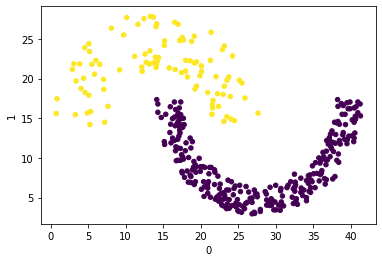

In [6]:
#visualize the dataset (with clusters)
jain.plot.scatter(x=0, y=1, c=2, colormap='viridis', colorbar=False);

In [7]:
re = jain[0]
im = jain[1]
v = np.array([complex(re[i], im[i]) for i in range(len(re))])
print(v.shape)

(373,)


In [13]:
#extract adjacency matrix
A = 1*(abs(v[:, np.newaxis] - v)<=4)
A = A - np.diag(np.diag(A))
N = A.shape[0]
G = nx.from_numpy_matrix(A)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 373
Number of edges: 7628
Average degree:  40.9008
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
15256


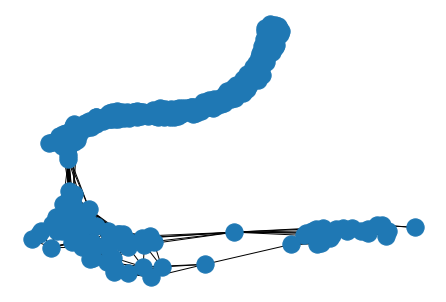

In [9]:
nx.draw(G)

In [24]:
r2 = nx.pagerank(G, personalization=q)
r2_v = np.array(list(r2.values()))

[1.83810349e-01 3.81297167e-02 6.47794155e-02 1.84751117e-02
 2.75918067e-02 2.75918067e-02 3.98568709e-02 6.84186407e-02
 6.79065589e-02 5.73545571e-02 2.81447176e-02 2.59017892e-02
 2.76543954e-02 3.05160869e-02 1.21453290e-02 1.93864312e-02
 3.07052676e-02 2.86332395e-02 3.26145507e-02 3.26145507e-02
 2.68323205e-02 2.33292780e-02 1.72752371e-02 1.55503199e-02
 1.42405231e-02 1.44880830e-03 5.68451032e-04 6.63246263e-04
 1.02253467e-02 1.53356556e-03 1.72514035e-03 9.01282884e-04
 7.58184427e-04 3.81488012e-04 3.32772876e-04 3.60034570e-04
 3.57970842e-04 5.06935231e-04 7.47321473e-04 8.19910371e-04
 1.47272402e-03 1.47272402e-03 1.55684568e-03 8.02166589e-04
 8.18000342e-04 8.49995472e-04 9.09604663e-04 8.47066885e-04
 8.47066885e-04 8.32300910e-04 3.72958531e-04 2.89081193e-04
 2.47036404e-04 2.55034281e-04 2.55034281e-04 1.82104719e-04
 2.20585023e-04 6.60433810e-05 8.29751584e-04 5.69550007e-04
 3.32582035e-04 3.44160839e-04 1.61241176e-04 3.77654111e-04
 2.47185542e-04 2.213457

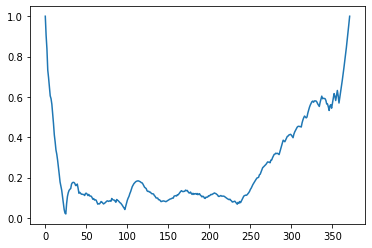

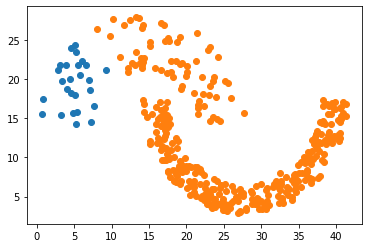

In [71]:
#infinite precision
#sweep
pos2 = np.flip(np.argsort(r2_v))
u1s = np.flip(np.sort(r2_v))
Nmax1 = np.argwhere(u1s>0)[-1].squeeze()
Ap = np.zeros((N,N))
for x,i in enumerate(pos2):
    for y,j in enumerate(pos2):
        Ap[x,y] = A[i,j]
conduct = conductance_sweep(Ap)
conduct = conduct[0:Nmax1]

plt.plot(conduct)
plt.show()

#minimum
mpos2 = np.argmin(conduct)

#communities
C1 = np.sort(pos2[0:mpos2+1])
C2 = np.sort(pos2[mpos2+2:])

#plot
x1 = [x.real for x in v[C1]]
y1 = [x.imag for x in v[C1]]
x2 = [x.real for x in v[C2]]
y2 = [x.imag for x in v[C2]]
plt.scatter(x1,y1)
plt.scatter(x2, y2)



In [39]:
#finite precision
pos2 = np.flip(np.argsort(r2_v))
u2s = np.flip(np.sort(r2_v))
Nmax = np.flip(np.argwhere(u2s>0))[0]
print(Nmax)
print(pos2)
print(A[pos2, pos2])
conduct = conductance_sweep(A[pos2, pos2])
conduct = conduct[1:Nmax-1]
print(len(conduct))

[372]
[  0   7   8   2   9   6   1  19  18  16  13  17  10  12   5   4  20  11
  21  15   3  22  23  24  14  28  30  42  29  40  41  25  46  31  45  48
  47  49  58  39  44  43  32  38  27  59  26  37  33  63  50  35  36  61
  34  60  51  54  53  64  52  66  65  56  55  67  62  70  71  68  69  72
  76  77  84  85  86  57  83  89  78 104  73  82  90  80  79 103  81  75
  94  74  91  95  88  87  96  93 105 115 113 106 102 124 118 126 127 119
 122 109 121 120 117 125 116 108 123 107 110 114 101 100 131 128  99 129
 137 130 139 132 138 136 135  98 134 111 140 141 112 143 133  97 144 142
 145 146 147 148 150 149 156 157 163 155 161 164 158 185 165 162 154 179
  92 180 181 178 175 159 171 174 173 188 168 184 151 160 176 195 152 170
 199 169 193 187 183 198 172 190 196 153 177 182 215 186 167 192 230 189
 205 229 197 203 232 206 221 204 227 201 200 207 194 166 220 226 228 213
 233 231 216 208 211 191 202 217 219 223 210 218 209 222 225 224 212 214
 236 273 235 272 234 263 271 265 264 243 253 

TypeError: only integer scalar arrays can be converted to a scalar index